In [1]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import pandas as pd
import requests
from io import StringIO
import re
from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_colwidth', None)

C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



In [2]:
sheet_name_lsit = ['Sci/2', 'Sci_Extra/1', 'Sci/1', 'Sci_Extra/2', 'Engineering/1', 'Engineering_Extra/1', 'Engineering/2', 'Engineering_Extra/2', 'SIIT/2', 'SIIT/1', 'Innovation_Extra/1', 'Innovation_Extra/2', 'CIS_Extra/1', 'CIS/1', 'CIS_Extra/2', 'CIS/2']

In [3]:
sheet_id = "1ExtEUwVLi5Y_mmqxNd0oX7WrWzj8n6TeBLcQg7Xu0GU"
dataframe = pd.DataFrame(columns=["code", "desc", "add1", "add2", "add3","ma"])

for sheet_name in sheet_name_lsit:
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    response = requests.get(url)
    decoded_content = response.content.decode('utf-8')
    data_tem =  pd.read_csv(StringIO(decoded_content))
    dataframe = pd.concat([dataframe, data_tem], ignore_index=True)

print(dataframe.shape)

(4272, 6)


In [4]:
dataframe.drop_duplicates(subset=["code"],inplace=True)
dataframe.dropna(subset=["desc"],inplace=True)
dataframe[dataframe["desc"].duplicated(keep="first")]

pattern = r"[A-Za-zก-ฮ]{1,2}\.? ?\d{3}"

def extract_courses(row):
    if isinstance(row, str):
        matches = re.findall(pattern, row)  
        return matches if matches else None  
    return None 

dataframe["cancel_course"] = dataframe["add1"].apply(extract_courses) + dataframe["add2"].apply(extract_courses)
dataframe.head()

,code,desc,add1,add2,add3,ma,cancel_course
0,AM100,"Basics concepts in Applied Mathematics, Mathematical Modeling, Operations Research and Computational Mathematics",[],[],[],sci,NaN
3,AM101,"Limit and continuity of single variable functions, the derivative and its applications, antiderivatives and indefinite integrals, techniques of integrations, definite integrals and applications of the definite integrals in geometry and physics, improper integrals and convergence tests, infinite series and convergence tests, power series and Theorem of Taylor series, software programme for calculus of single variable functions.",['disciplinary course(s): ไม่นับหน่วยกิตให้ผืที่กำลังศึกษาหรือสอบได้ ค.111 หรือ ค.211 หรือ ค.216 หรือ ค.218'],"['consecutive course(s): AM102, ST326']",[],sci,"[ค.111, ค.211, ค.216, ค.218, AM102, ST326]"
5,AM102,"Transformation of coordinate systems, polar coordinates and graphing, vectors, lines and planes in 3D- space, functions of several variables and suface plot, limits and continuity of several variables functions, partial derivatives, higher-order partial derivatives, implicit functions theorem, applications of partial derivatives in optimization, multiple integrations, differential vector calculus, introduction to line integrals and surface integrals, Gauss’s Theorem, Green’s Theorem and Stokes’ Theorem, software programme for calculus of several variable functions.",['disciplinary course(s): AM101'],"['consecutive course(s): AM201, AM311, AM327, MA316, MA351, MA412, ST226, ST321, ST327']",[],sci,"[AM101, AM201, AM311, AM327, MA316, MA351, MA412, ST226, ST321, ST327]"
7,AM151,"Symbolic logic, methods of proof, proof of quantifier sentences, real number system, properties of real numbers, sets, properties and theorems of sets, relations, equivalence relations, partial order relations, functions, and types of functions.","['consecutive course(s): AM211, AM457, MA332, MA337, MA338, MA366, MA368']",[],[],sci,NaN
8,AM200,"Logic, algebra of sets, relations and functions, recurrence relations, generating functions, basic concepts in graph theory, number representation in computer, Boolean algebra and combinatorial circuits, finite-state machines, finite automata, basic concepts in algebraic system. Note : 1. This subject is equivalent to CS 101, Discrete Structures. 2. There is no credit for students who currently taking or have earned credits of CS 101",['disciplinary course(s): 1.วิชานี้เทียบเท่า(equivalent)กับวิชา คพ.101 โครงสร้างแบบไม่ต่อเนื่อง 2.ไม่นับหน่วยกิตให้ผู้ที่กำลังศึกษา หรือสอบได้คพ.101'],"['consecutive course(s): AM346, AM411, AM448, AM451, MA338, MA366, MA367']",[],sci,"[คพ.101, คพ.101, AM346, AM411, AM448, AM451, MA338, MA366, MA367]"


In [5]:
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-large-zh") 
model2 = AutoModel.from_pretrained("BAAI/bge-large-zh") 
model = SentenceTransformer('paraphrase-mpnet-base-v2') 

In [6]:
def create_embeddings():
    dis = list(dataframe["desc"])
    embeddings = model.encode(dis)
    return embeddings
dataframe["embed"] = create_embeddings().tolist()

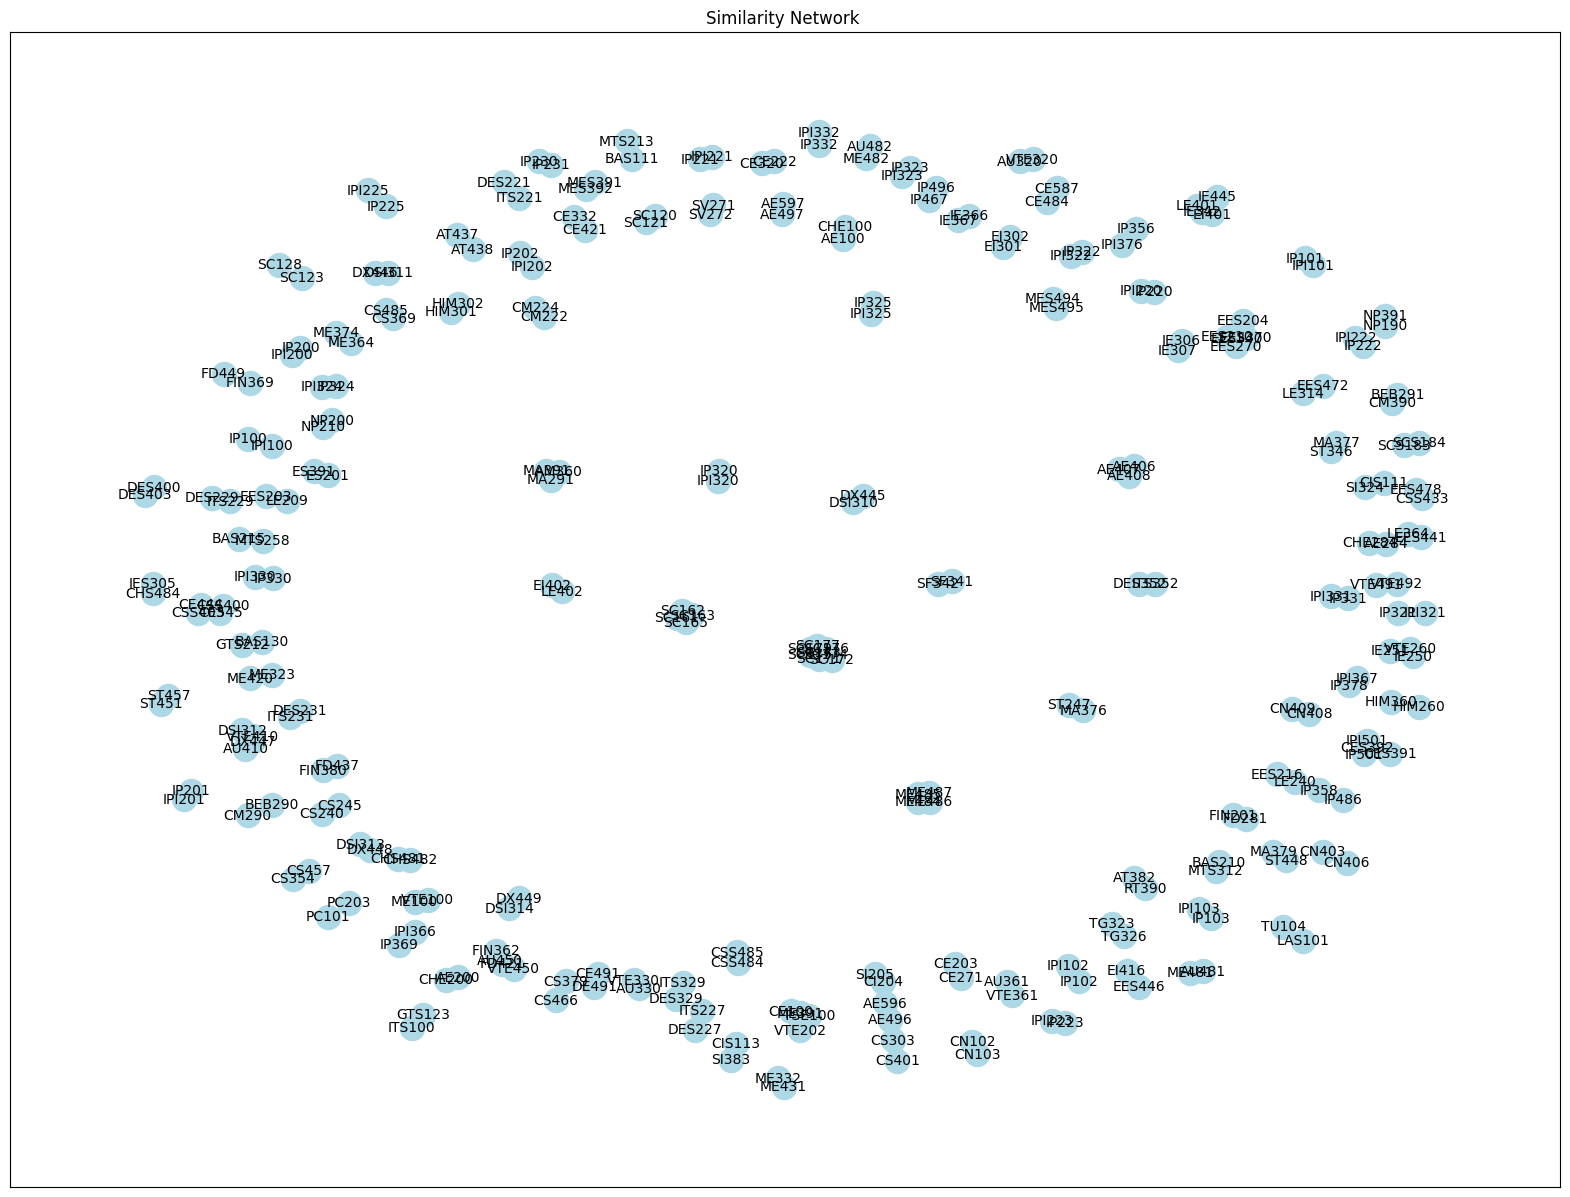

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

# คำนวณค่า cosine similarity สำหรับทุกคู่ของ embeddings
def compute_similarity_matrix(dataframe, threshold=0.95):
    embeddings = np.vstack(dataframe["embed"].dropna().to_numpy())   # รวม embeddings เป็น array
    similarity_matrix = cosine_similarity(embeddings)  # คำนวณค่า similarity matrix

    pairs = []
    for i in range(len(similarity_matrix)):
    for j in range(i + 1, len(similarity_matrix)):
        if similarity_matrix[i, j] > threshold:
            # Check if the pair is in the cancel_course column
            course_i = dataframe.iloc[i]["course_code"]  # Get course code for row i
            course_j = dataframe.iloc[j]["course_code"]  # Get course code for row j
            cancel_i = dataframe.iloc[i]["cancel_course"]  # Get canceled courses for row i
            cancel_j = dataframe.iloc[j]["cancel_course"]  # Get canceled courses for row j

            # Only add the pair if it is not canceled for both courses
            if course_j not in cancel_i and course_i not in cancel_j:
                pairs.append((i, j))  # Append the pair if conditions are met

    dataframe["valid_pairs"] = dataframe["course_code"].apply(
        lambda x: [i for i in pairs if x in i]
    )
                
    return pairs

def plot_similarity_graph(dataframe):
    codes = dataframe["code"].tolist()          # นำโค้ดมาใช้เป็นป้ายกำกับ
    pairs = compute_similarity_matrix(dataframe)

    # สร้าง Network Graph
    G = nx.Graph()
    G.add_edges_from([(codes[i], codes[j]) for i, j in pairs])  # ใช้ code เป็นป้ายกำกับแต่ละโหนด

    # Plot กราฟ
    plt.figure(figsize=(20, 15))
    pos = nx.spring_layout(G, seed=42)  # Layout กราฟ
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")  # แสดงชื่อโหนด

    plt.title(f"Similarity Network ")
    plt.show()

plot_similarity_graph(dataframe)


In [26]:
print(dataframe[dataframe["code"]=="IP230"])

       code  \
4008  IP230   

                                                                                                                              desc  \
4008  Articles from intermediate English journals and books, to get acquaintance with vocabularies and concepts in social sciences   

                                   add1                              add2  \
4008  ['disciplinary course(s): TU105']  ['consecutive course(s): IP231']   

     add3   ma   cancel_course  \
4008   []  cis  [TU105, IP231]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

TF-IDF